In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_rows = 500   
pd.options.display.max_columns = 20   
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

In [286]:
df = pd.read_csv('corp_final.csv')
df.drop(['기업명','기업구분','지역','홈페이지'], axis=1, inplace=True)
df.head()

,기업구분코드,사원수,업력,입사율(%),퇴사율(%),이직율(%),별점
0,3.0000,52,4.0000,114.7100,64.7100,56.4100,4.3000
1,3.0000,930,17.0000,89.9400,97.8400,108.7800,2.3000
2,3.0000,20,10.0000,40.0000,30.0000,75.0000,3.0000
3,3.0000,140,14.0000,120.0000,100.0000,83.3300,3.3000
4,3.0000,67,23.0000,42.8600,50.0000,116.6600,2.4000


In [287]:
df['가중치'] = np.nan
df.head(3)

,기업구분코드,사원수,업력,입사율(%),퇴사율(%),이직율(%),별점,가중치
0,3.0000,52,4.0000,114.7100,64.7100,56.4100,4.3000,NaN
1,3.0000,930,17.0000,89.9400,97.8400,108.7800,2.3000,NaN
2,3.0000,20,10.0000,40.0000,30.0000,75.0000,3.0000,NaN


In [288]:
df.describe()

,기업구분코드,사원수,업력,입사율(%),퇴사율(%),이직율(%),별점,가중치
count,174.0000,174.0000,174.0000,174.0000,174.0000,174.0000,174.0000,0.0000
mean,2.8448,304.4368,15.3276,63.4593,48.9160,92.4985,2.8379,NaN
std,0.6835,994.3643,9.7667,58.9875,42.2990,52.4883,0.6816,NaN
min,1.0000,2.0000,1.0000,7.1400,3.7000,22.2300,1.0000,NaN
25%,3.0000,30.5000,7.0000,28.6250,23.8425,63.6300,2.4000,NaN
50%,3.0000,76.0000,14.0000,43.0500,38.2100,81.2450,2.7000,NaN
75%,3.0000,211.2500,21.0000,82.7475,60.0000,105.2100,3.2750,NaN
max,4.0000,9658.0000,55.0000,400.0000,316.6700,403.8300,5.0000,NaN


In [289]:
df['별점'].quantile(.9)

3.7

In [291]:
for idx, rows in df.iterrows():  # 기업 구분 (20%) 사원 수 (10%) 업력 (10%) 이직율(30%) 별점 (30%)
    weight = 0
    print(df.iloc[idx,])
    # 기업구분에 따라서
    if df.iloc[idx,1] == 3.0000:
        weight += 10*0.2
    elif df.iloc[idx,1] == 2.0000:
        weight += 20*0.2
    elif df.iloc[idx,1] == 1.0000:
        weight += 30*0.2
    elif df.iloc[idx,1] == 4.0000:
        weight += 15*0.2
    
    # 사원수에 따라서    
    if df.iloc[idx,2] < 30.50:
        weight += 10*0.1
    elif df.iloc[idx,2] < 76:
        weight += 20*0.1
    elif df.iloc[idx,2] < 211.25:
        weight += 30*0.1
    else:
        weight += 40*0.1
        
    # 엽력에 따라서   데이터 추가 필요 
    if df.iloc[idx,3] < 7:
        weight += 10*0.1
    elif df.iloc[idx,3] < 14:
        weight += 20*0.1
    elif df.iloc[idx,3] < 21:
        weight += 30*0.1
    else:
        weight += 40*0.1
    
        #이직율에 따라서
    if df.iloc[idx,-3] > 105.21:
        weight += 0
    elif df.iloc[idx,-3] > 81.2450:
        weight += 10*0.3
    elif df.iloc[idx,-3] > 63.6300:
        weight += 20*0.3
    else:             # 너무 낮은 경우 총 인원수 자체가 작은 경우도 있음. 
        weight += 30*0.3

    # 별점에 따라서 
    if df.iloc[idx,-2] <= 2.1:
        weight += 0
    elif df.iloc[idx,-2] <= 2.4:
        weight += 10*0.3    
    elif df.iloc[idx,-2] <= 2.7:
        weight += 15*0.3
    elif df.iloc[idx,-2] <= 3.275:
        weight += 20*0.3
    elif df.iloc[idx,-2] <= 3.7:
        weight += 25*0.3
    else:
        weight += 35*0.3

    
    df.loc[idx, '가중치'] = weight

기업구분코드     3.0000
사원수       52.0000
업력         4.0000
입사율(%)   114.7100
퇴사율(%)    64.7100
이직율(%)    56.4100
별점         4.3000
가중치       24.5000
Name: 0, dtype: float64
기업구분코드     3.0000
사원수      930.0000
업력        17.0000
입사율(%)    89.9400
퇴사율(%)    97.8400
이직율(%)   108.7800
별점         2.3000
가중치        8.0000
Name: 1, dtype: float64
기업구분코드    3.0000
사원수      20.0000
업력       10.0000
입사율(%)   40.0000
퇴사율(%)   30.0000
이직율(%)   75.0000
별점        3.0000
가중치      17.0000
Name: 2, dtype: float64
기업구분코드     3.0000
사원수      140.0000
업력        14.0000
입사율(%)   120.0000
퇴사율(%)   100.0000
이직율(%)    83.3300
별점         3.3000
가중치       15.5000
Name: 3, dtype: float64
기업구분코드     3.0000
사원수       67.0000
업력        23.0000
입사율(%)    42.8600
퇴사율(%)    50.0000
이직율(%)   116.6600
별점         2.4000
가중치        8.0000
Name: 4, dtype: float64
기업구분코드     3.0000
사원수       80.0000
업력         4.0000
입사율(%)   164.2900
퇴사율(%)    84.2900
이직율(%)    51.3100
별점         2.3000
가중치       17.0000
Name: 5, dtype: float64


In [292]:
df.describe()

,기업구분코드,사원수,업력,입사율(%),퇴사율(%),이직율(%),별점,가중치
count,174.0000,174.0000,174.0000,174.0000,174.0000,174.0000,174.0000,174.0000
mean,2.8448,304.4368,15.3276,63.4593,48.9160,92.4985,2.8379,14.5316
std,0.6835,994.3643,9.7667,58.9875,42.2990,52.4883,0.6816,4.8751
min,1.0000,2.0000,1.0000,7.1400,3.7000,22.2300,1.0000,3.0000
25%,3.0000,30.5000,7.0000,28.6250,23.8425,63.6300,2.4000,11.0000
50%,3.0000,76.0000,14.0000,43.0500,38.2100,81.2450,2.7000,14.0000
75%,3.0000,211.2500,21.0000,82.7475,60.0000,105.2100,3.2750,18.5000
max,4.0000,9658.0000,55.0000,400.0000,316.6700,403.8300,5.0000,24.5000


In [293]:
df['가중치'].quantile(.6)

15.5

In [294]:
df['추천'] = np.nan

In [295]:
for idx, rows in df.iterrows():
    if df.iloc[idx,-2] >= 15.5:
        df.iloc[idx,-1] = 1
    else:
        df.iloc[idx,-1] = 0

In [296]:
df.head(2)

,기업구분코드,사원수,업력,입사율(%),퇴사율(%),이직율(%),별점,가중치,추천
0,3.0000,52,4.0000,114.7100,64.7100,56.4100,4.3000,24.5000,1.0000
1,3.0000,930,17.0000,89.9400,97.8400,108.7800,2.3000,8.0000,0.0000


In [297]:
X = df.drop(columns='추천')
Y = df['추천']

# x_train, x_test 데이터 생성
x_train, x_test, y_train, y_test  = train_test_split(X, Y, test_size=0.2, stratify= Y, random_state=0)

x_train.shape, y_train.shape, x_test.shape

((139, 8), (139,), (35, 8))

In [267]:
# train score, test score, roc_auc_score 
def get_scores(model, xtrain, xtest, ytrain, ytest):
    A = model.score(xtrain, ytrain)
    B = model.score(xtest, ytest)
    ypred = model.predict(xtest)
    C = roc_auc_score(ytest, ypred)  
    return '{:.4f} {:.4f} {:.4f}'.format(A, B, C)
# 모델선택 
def make_models(xtrain, xtest, ytrain, ytest):
    model1 = LogisticRegression(max_iter=500).fit(xtrain, ytrain)
    print('Logistic', get_scores(model1, xtrain, xtest, ytrain, ytest))
    for k in range(1, 10):
        model2 = KNeighborsClassifier(k).fit(xtrain, ytrain)
        print('KNN', k, get_scores(model2, xtrain, xtest, ytrain, ytest))

    # overfitting
    model3 = DecisionTreeClassifier(random_state=0).fit(xtrain, ytrain)
    print('DecisionTree', get_scores(model3, xtrain, xtest, ytrain, ytest))

    # overfitting 해결
    for d in range(3, 8):
        model3 = DecisionTreeClassifier(max_depth=d,random_state=0).fit(xtrain, ytrain)
        print('DecisionTree', d, get_scores(model3, xtrain, xtest, ytrain, ytest))

    # overfitting
    model4 = RandomForestClassifier(random_state=0).fit(xtrain, ytrain)
    print('RandomForest', get_scores(model4, xtrain, xtest, ytrain, ytest))

    # overfitting 해결
    for d in range(3, 8):
        model4 = RandomForestClassifier(100, max_depth=d, random_state=0).fit(xtrain, ytrain)
        print('RandomForest', d, get_scores(model4, xtrain, xtest, ytrain, ytest))

    model5 = XGBClassifier().fit(xtrain, ytrain)
    print('XGB', get_scores(model5, xtrain, xtest, ytrain, ytest))


In [268]:
#성능평가 
def get_other_scores(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    print(f'accuracy  : {accuracy:.4f}')
    print(f'precision : {precision:.4f}')
    print(f'recall    : {recall:.4f}')
    print(f'f1        : {f1:.4f}')

In [270]:
make_models(x_train,x_test,y_train,y_test)

Logistic 1.0000 0.9429 0.9424
KNN 1 1.0000 0.7429 0.7533
KNN 2 0.8561 0.7143 0.7072
KNN 3 0.8849 0.6857 0.6957
KNN 4 0.8129 0.6857 0.6809
KNN 5 0.8273 0.6571 0.6645
KNN 6 0.7986 0.6286 0.6234
KNN 7 0.7698 0.6286 0.6332
KNN 8 0.7842 0.6571 0.6546
KNN 9 0.7986 0.6857 0.6859
DecisionTree 1.0000 1.0000 1.0000
DecisionTree 3 1.0000 1.0000 1.0000
DecisionTree 4 1.0000 1.0000 1.0000
DecisionTree 5 1.0000 1.0000 1.0000
DecisionTree 6 1.0000 1.0000 1.0000
DecisionTree 7 1.0000 1.0000 1.0000
RandomForest 1.0000 1.0000 1.0000
RandomForest 3 1.0000 1.0000 1.0000
RandomForest 4 1.0000 1.0000 1.0000
RandomForest 5 1.0000 1.0000 1.0000
RandomForest 6 1.0000 1.0000 1.0000
RandomForest 7 1.0000 1.0000 1.0000
XGB 1.0000 0.9429 0.9474


In [271]:
# KNN 2 0.8561 0.7143 0.7072

In [272]:
model = KNeighborsClassifier(2).fit(x_train, y_train)
print(get_scores(model, x_train, x_test, y_train, y_test))  # train score, test score, roc_auc_score 
get_other_scores(model,x_test,y_test)

0.8561 0.7143 0.7072
accuracy  : 0.7143
precision : 0.7143
recall    : 0.6250
f1        : 0.6667


In [273]:
y_pred = model.predict(x_test)
label=['비추천', '추천']
a = confusion_matrix(y_test, y_pred)
b = pd.DataFrame(a, columns=label, index=label)
b

,비추천,추천
비추천,15,4
추천,6,10


### robust scaler 처리

In [274]:
scaler = RobustScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)

x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
기업구분코드,139.0000,-0.1727,0.7012,-2.0000,0.0000,0.0000,0.0000,1.0000
사원수,139.0000,1.0867,4.0135,-0.3551,-0.2272,0.0000,0.7728,34.1149
업력,139.0000,0.1478,0.7460,-0.9231,-0.4615,0.0000,0.5385,3.2308
입사율(%),139.0000,0.3572,1.1091,-0.6587,-0.2648,0.0000,0.7352,6.6996
퇴사율(%),139.0000,0.3393,1.3001,-0.9713,-0.3897,0.0000,0.6103,8.1003
이직율(%),139.0000,0.3150,1.3049,-1.3738,-0.3997,0.0000,0.6003,7.5088
별점,139.0000,0.0585,0.8401,-2.2500,-0.5000,0.0000,0.5000,2.7500
가중치,139.0000,0.0604,0.6521,-1.4667,-0.4000,0.0000,0.6000,1.4000


In [275]:
make_models(x_train,x_test,y_train,y_test)

Logistic 0.9928 0.9143 0.9112
KNN 1 1.0000 0.8286 0.8322
KNN 2 0.9640 0.8571 0.8536
KNN 3 0.9784 0.8571 0.8586
KNN 4 0.9424 0.8857 0.8750
KNN 5 0.9424 0.8571 0.8586
KNN 6 0.9065 0.8571 0.8487
KNN 7 0.9137 0.9143 0.9112
KNN 8 0.8849 0.8857 0.8799
KNN 9 0.9137 0.8857 0.8849
DecisionTree 1.0000 0.9429 0.9474
DecisionTree 3 1.0000 0.9429 0.9474
DecisionTree 4 1.0000 0.9429 0.9474
DecisionTree 5 1.0000 0.9429 0.9474
DecisionTree 6 1.0000 0.9429 0.9474
DecisionTree 7 1.0000 0.9429 0.9474
RandomForest 1.0000 0.9429 0.9474
RandomForest 3 1.0000 0.9429 0.9474
RandomForest 4 1.0000 0.9429 0.9474
RandomForest 5 1.0000 0.9429 0.9474
RandomForest 6 1.0000 0.9429 0.9474
RandomForest 7 1.0000 0.9429 0.9474
XGB 1.0000 0.9429 0.9474


#### robust scaler처리 후 조금 더 정확해짐

In [276]:
# KNN 7 0.9137 0.9143 0.9112

In [277]:
model =  KNeighborsClassifier(7).fit(x_train, y_train)
print(get_scores(model, x_train, x_test, y_train, y_test))  # train score, test score, roc_auc_score 
get_other_scores(model,x_test,y_test)

0.9137 0.9143 0.9112
accuracy  : 0.9143
precision : 0.9333
recall    : 0.8750
f1        : 0.9032


In [278]:
y_pred = model.predict(x_test)
label=['비추천', '추천']
a = confusion_matrix(y_test, y_pred)
b = pd.DataFrame(a, columns=label, index=label)
b

,비추천,추천
비추천,18,1
추천,2,14


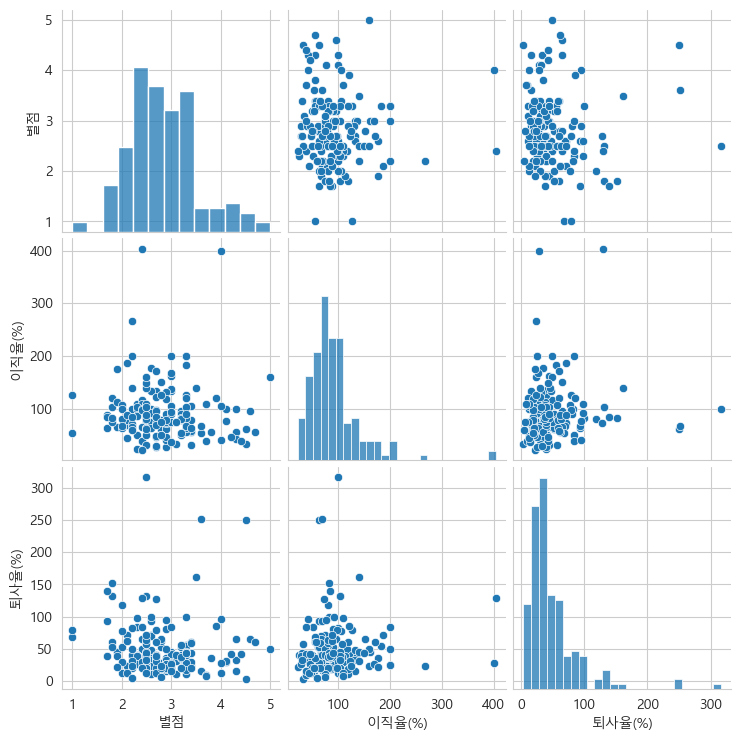

In [279]:
sns.pairplot(df[['별점','이직율(%)','퇴사율(%)']])

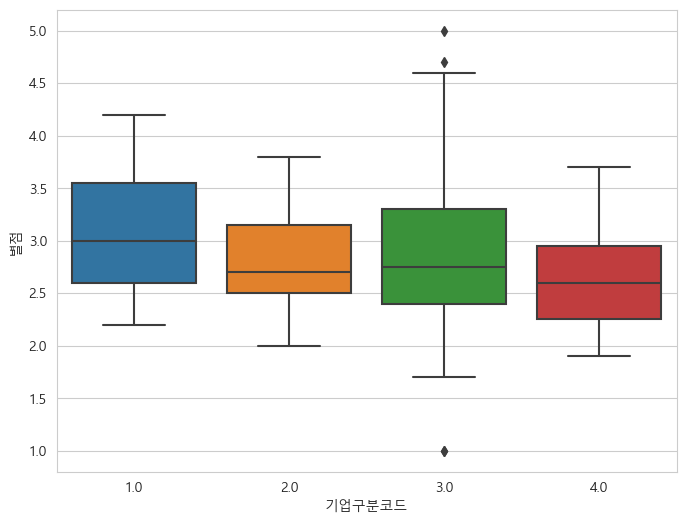

In [282]:
plt.figure(figsize=(8,6))
sns.boxplot(x="기업구분코드", y="별점", data = df)
plt.show()

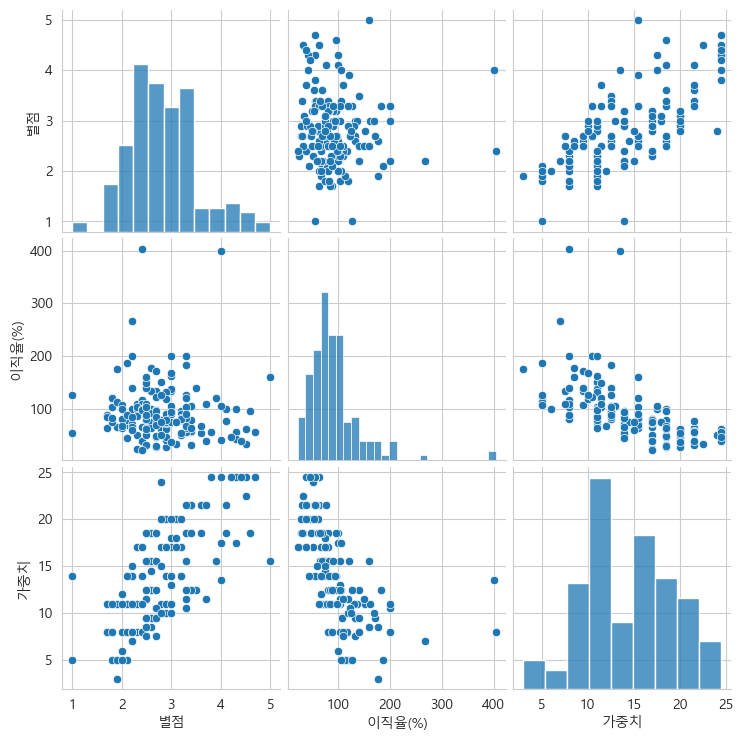

In [283]:
sns.pairplot(df[['별점','이직율(%)','가중치']])

Text(0.5, 1.0, '별점 분포 확인')

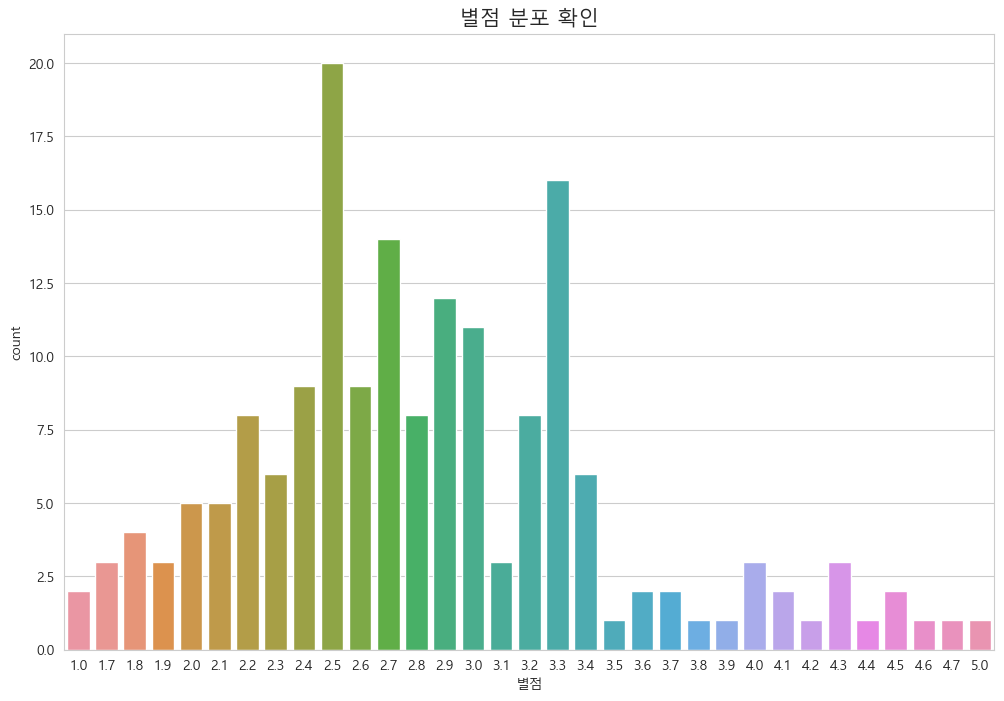

In [284]:
# 별점의 분포가 어떤지 : countplot 은 데이터의 개수를 표시하는 플롯
plt.figure(figsize=(12, 8))
plt.title
sns.countplot(data=df, x='별점');
plt.title('별점 분포 확인', loc='center', fontsize=15) 

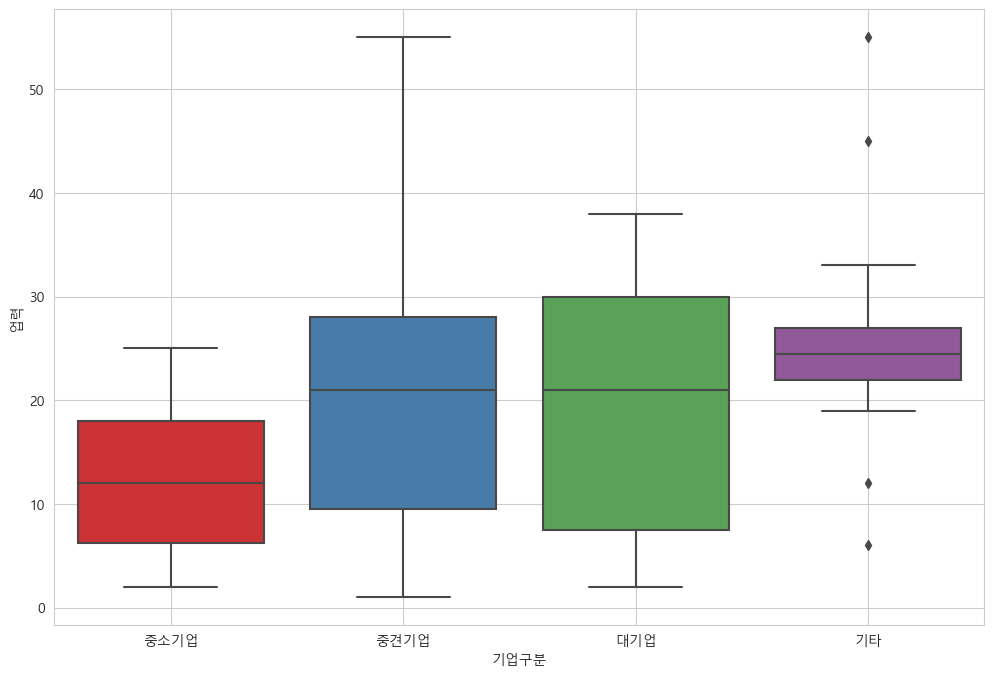

In [134]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="기업구분", y="업력", data=df, palette="Set1")
plt.grid(True)
plt.show()

<AxesSubplot: >

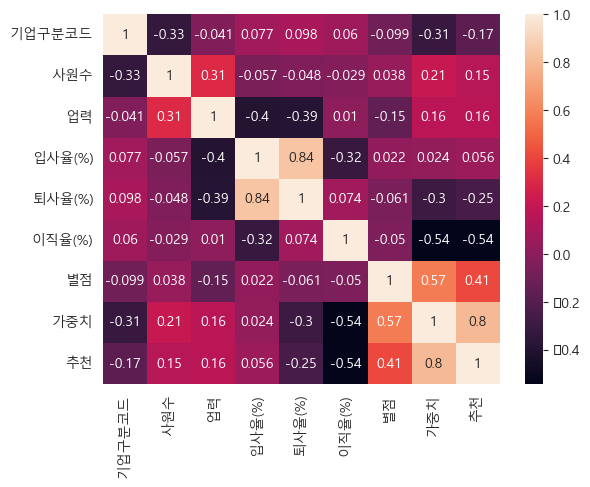

In [135]:
sns.heatmap(df.corr(),annot=True)

In [170]:
df[['추천','가중치']].groupby('추천').mean()

,가중치
추천,
0.0000,13.6289
1.0000,22.0974


Text(0.5, 1.0, '업력에 따른 별점')

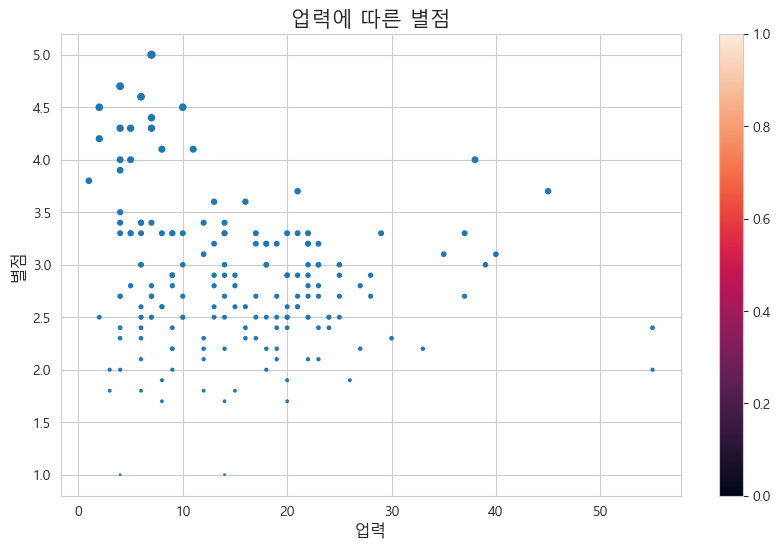

In [181]:
plt.figure(figsize=(10,6))
plt.scatter(df['업력'],df['별점'],s=a)
plt.colorbar()
plt.xlabel('업력',size=12)
plt.ylabel('별점',size=12)
plt.title("업력에 따른 별점",size=15)